# Task 3: Please use multiple linear regression to predict video quality (VQ) based on fragmentation (VF), unclearness (VU) and discontinuity (VD)
## Check if the linearity assumption is met (check the residual plot)
## Please report the results in terms of RMSE, R-squared and spearman correlation on the dataset

In [1]:
# install.packages('dplyr')      # processing 
# install.packages('gdata')      # file reading
# install.packages('tidyverse')  # includes regression algorithms
# install.packages('Hmisc')      # correlation matricies

In [2]:
library(readxl)     # reading in data
library(tidyverse)  # regression algorithms
library(ggplot2)    # residual plot
library(Hmisc)      # correlation matricies

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --
v ggplot2 3.2.1     v purrr   0.3.3
v tibble  2.1.3     v dplyr   0.8.3
v tidyr   1.0.0     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Loading required package: lattice
Loading required package: survival
Loading required package: Formula

Attaching package: 'Hmisc'

The following objects are masked from 'package:dplyr':

    src, summarize

The following objects are masked from 'package:base':

    format.pval, units



# Global constants for MOS prediction & outlier removal (optional)

In [3]:
# VU, VF, VD, VQ values are each MOS of these attributes
predict_MOS <- TRUE

# optional univariate outlier removal
remove_univariate_outliers <- TRUE

# Getter for input data set based on global constants (features from Task 1, Task 2 included)

In [4]:
get_gaming_data <- function() {
    # read in data set
    gaming_data <- read_excel("datasets/DB01_gaming_video_quality_dataset.xlsx")
    
    # Compute MOS per Game, Condition [Task 1] 
    mos_per_condition_and_game <- gaming_data %>%
                              dplyr::group_by(Game, Condition) %>%
                              dplyr::summarise(meanVQ = mean(VQ), meanVF = mean(VF), meanVU = mean(VU), meanVD = mean(VD)) %>%
                              dplyr::select(Game, Condition, meanVQ, meanVF, meanVU, meanVD)
    
    # Feature Transformation [Task 2]
    gaming_data_feature_transformation <- gaming_data %>% 
                                        dplyr::mutate(Number_Of_Pixels = ifelse(Resolution == 480, 480*720, 
                                                                    ifelse(Resolution == 720, 720*1280, 
                                                                          ifelse(Resolution == 1080, 1080*1920, -1)
                                                                          )
                                                                  )
                                              ) %>%
                                        dplyr::mutate(Bits_Per_Pixel = Bitrate / Number_Of_Pixels) %>%
                                        dplyr::select(Game, Condition, VF, VU, VD, VQ, Framerate, Number_Of_Pixels, Bits_Per_Pixel)
    
    # Merge data for single data source
    gaming_data <- merge(mos_per_condition_and_game, gaming_data_feature_transformation)
    
    # either predict MOS values OR single ratings
    if(predict_MOS) {
        gaming_data <- unique(gaming_data %>% dplyr::select(Game, Condition, meanVQ, meanVF, meanVU, meanVD, Framerate, Number_Of_Pixels, Bits_Per_Pixel)) %>% 
                       rename(VF = meanVF, VU = meanVU, VD = meanVD, VQ = meanVQ) %>% 
                       arrange(Game, Condition)
    } else {
        gaming_data <- gaming_data %>% 
                       arrange(Game, Condition)
    }
    
    # formatting
    rownames(gaming_data) <- NULL
    
    # optional outlier removal (only univariate outliers in VD)
    if(remove_univariate_outliers) {
        bounds <- gaming_data %>% summarise(lower = quantile(VD, c(0.25)), upper = quantile(VD, c(0.75))) %>% 
                        mutate(IQR = upper - lower) %>% 
                        mutate(lower_bound_VD = lower - 1.5*IQR, upper_bound_VD = upper + 1.5*IQR) %>% 
                        dplyr::select(lower_bound_VD, upper_bound_VD)

        gaming_data <- gaming_data %>% 
                            dplyr::filter(VD >= as.double(bounds$lower_bound_VD)) %>% 
                            dplyr::filter(VD <= as.double(bounds$upper_bound_VD))
    }
    
    gaming_data
}

get_gaming_data()

Game,Condition,VQ,VF,VU,VD,Framerate,Number_Of_Pixels,Bits_Per_Pixel
Game1,4,2.948,2.796,3.204,4.840,30,921600,0.0010850694
Game1,5,4.112,3.760,4.392,4.924,30,2073600,0.0019290123
Game1,15,1.988,2.232,2.260,5.092,30,345600,0.0008680556
Game1,19,3.068,3.724,2.876,5.092,60,345600,0.0057870370
Game1,25,5.080,5.340,4.544,5.536,60,921600,0.0542534722
Game1,33,2.568,2.344,3.208,4.744,60,921600,0.0010850694
Game1,34,2.740,3.400,2.440,4.956,60,345600,0.0028935185
Game1,35,3.876,4.936,3.368,5.316,60,345600,0.0173611111
Game1,36,2.964,2.492,4.216,4.916,60,2073600,0.0009645062
Game1,39,4.424,4.584,4.252,4.972,30,921600,0.0043402778


# Set input data set globally for reusability

In [5]:
# make data set globally accessible for reusability
gaming_data <- get_gaming_data()

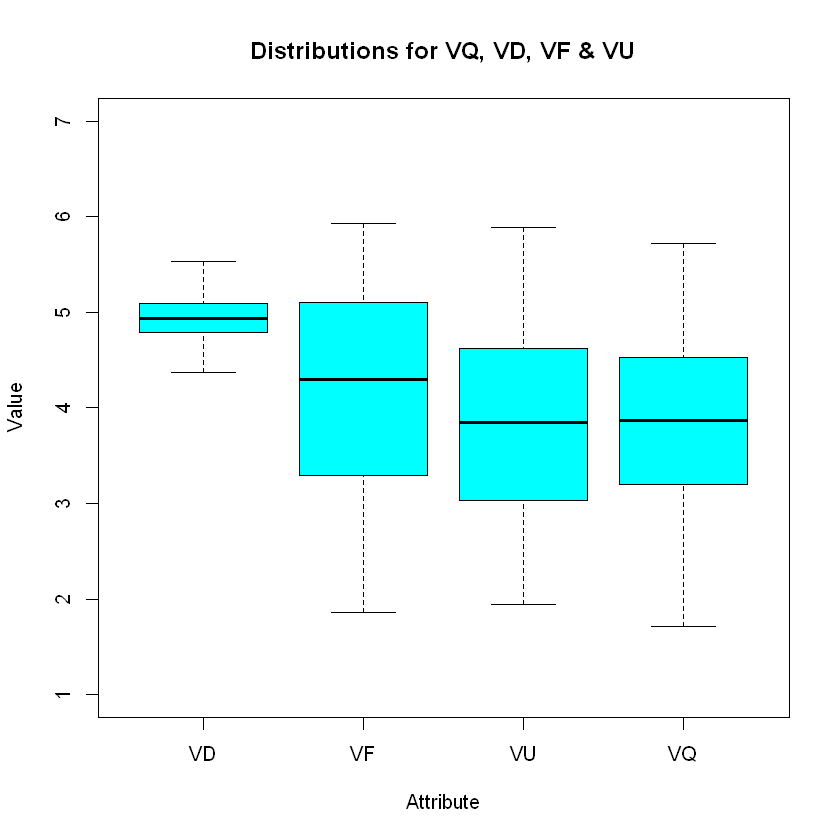

In [6]:
# visualize distributions (after optional outlier removal)
boxplot(gaming_data$VD, gaming_data$VF, gaming_data$VU, gaming_data$VQ, 
        main="Distributions for VQ, VD, VF & VU", 
        xlab='Attribute', ylab='Value', 
        ylim = c(1,7), 
        col = 69,
        names=c('VD', 'VF', 'VU', 'VQ'))

# Define helper functions

In [7]:
# prints model summary, RMSE, adjusted R-Squared values & optionally Spearman correlation between variables incl. p values
print_statistics <- function(model, include_spearman=FALSE) {
    summary <- summary(model)
    rmse <- sqrt(mean((as.vector(gaming_data$VQ) - as.vector(fitted(model)))^2))
    
    print(paste0('RMSE: ', round(rmse, digits=5)))
    print(paste0('Adjusted R-Squared (necessary as multiple explanatory variables): ', 
                 round(summary$adj.r.squared, digits=5)))
    
    if(missing(include_spearman) == FALSE && include_spearman == TRUE) {
        corr_data_spearman <- rcorr(as.matrix(gaming_data %>% dplyr::select(VF,VD,VU,VQ)), type=c("spearman"))
        include <- upper.tri(corr_data_spearman$r) # correlation matrix symmetric: scratch data below main diagonal not to have same pairs twice

        correlation_pairs_spearman <- data.frame(Variable_1 = rownames(corr_data_spearman$r)[row(corr_data_spearman$r)[include]],     # get row names
                                                 Variable_2 = rownames(corr_data_spearman$r)[col(corr_data_spearman$r)[include]],    # get column names
                                                 r_spearman =(corr_data_spearman$r)[include],                             
                                                 p_value = corr_data_spearman$P[include]) 
        
        # append correlation for VQ & predicted VQ
        corr_prediction_VQ <- rcorr(as.matrix(cbind(gaming_data %>% dplyr::select(VQ), predict(model))), type=c("spearman"))
        correlation_pairs_spearman <- correlation_pairs_spearman %>% add_row(Variable_1 = 'VQ', Variable_2 = 'Predicted_VQ', 
                                               r_spearman = as.double(corr_prediction_VQ$r[1,2]), 
                                               p_value = as.double(corr_prediction_VQ$P[1,2]))
        return(correlation_pairs_spearman)
    }
}

In [8]:
# draws residual plot for passed fitted values and residuals
draw_residual_plot <- function(y_hat, residuals) {

    ggplot(as.data.frame(cbind(y_hat, residuals)), aes(x = y_hat, y = residuals)) + 
    geom_point(color="darkred") + 
    scale_x_continuous(breaks=seq(0,7,1)) + 
    coord_cartesian(xlim=c(1,7)) + 
    labs(x = "Fitted Values", y = "Residuals") + 
    geom_hline(yintercept = 0, linetype = "dashed") +
    ggtitle("Residual Plot for Multiple Linear Regression Model:\n(VF, VU, VD) -> VQ") + 
    theme( panel.background = element_rect(fill = '#d7f5f2', colour = 'darkred'), strip.background = element_rect(fill='#d7f5f2', colour = 'darkred'),
                  strip.text = element_text(size=15, colour='darkred')) 
}

In [9]:
draw_model_correlation_plot <- function(VQ, predicted_VQ) {
    model_dataframe <- as.data.frame(cbind(VQ, predicted_VQ))
    
    ggplot(model_dataframe, aes(x = predicted_VQ, y = VQ)) +
    geom_point(aes(x = predicted_VQ, y = VQ), color="black") +
    scale_x_continuous(breaks=seq(0,7,1)) + 
    scale_y_continuous(breaks=seq(0,7,1)) + 
    geom_smooth(method = "lm", se = FALSE, color = "darkred") +
    coord_cartesian(xlim=c(1,7), ylim=c(1,7)) + 
    labs(x = "Predicted VQ", y = "True VQ") + 
    ggtitle("Correlation Scatter Plot for results of fitted \nMultiple Linear Regression Model") + 
    theme( panel.background = element_rect(fill = '#d7f5f2', colour = 'darkred'), strip.background = element_rect(fill='#d7f5f2', colour = 'darkred'),
                  strip.text = element_text(size=15, colour='darkred')) 
    
}

In [10]:
# returns fitted Multiple Linear regression model based on predicted attributes
# if no argument provided: ground truth values taken from data set
get_trained_VQ_model <- function(predicted=NULL) {
    if(missing(predicted) || is.null(predicted)) {
        gaming_data <- get_gaming_data()
        return(lm(VQ ~ VF + VU + VD, data = gaming_data))
    } else {
        return(lm(VQ ~ VF_predicted + VU_predicted + VD_predicted, data = predicted))
    }
}

# Print summary, statistics and residual plot for fitted model

In [11]:
model <- get_trained_VQ_model()
y_hat <- fitted(model)
residuals <- resid(model)

summary(model)
print_statistics(model, TRUE)


Call:
lm(formula = VQ ~ VF + VU + VD, data = gaming_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.33717 -0.10915 -0.00267  0.09231  0.40584 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.08660    0.29567  -3.675 0.000339 ***
VF           0.43559    0.01545  28.193  < 2e-16 ***
VU           0.54691    0.01675  32.655  < 2e-16 ***
VD           0.20213    0.06021   3.357 0.001016 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1531 on 139 degrees of freedom
Multiple R-squared:  0.9755,	Adjusted R-squared:  0.9749 
F-statistic:  1842 on 3 and 139 DF,  p-value: < 2.2e-16


[1] "RMSE: 0.1509"
[1] "Adjusted R-Squared (necessary as multiple explanatory variables): 0.97493"


Variable_1,Variable_2,r_spearman,p_value
VF,VD,0.18051694,0.03096833
VF,VU,0.62902031,0.00000000
VD,VU,0.08263548,0.32650246
VF,VQ,0.86818969,0.00000000
VD,VQ,0.16062336,0.05531671
VU,VQ,0.89167341,0.00000000
VQ,Predicted_VQ,0.98609907,0.00000000


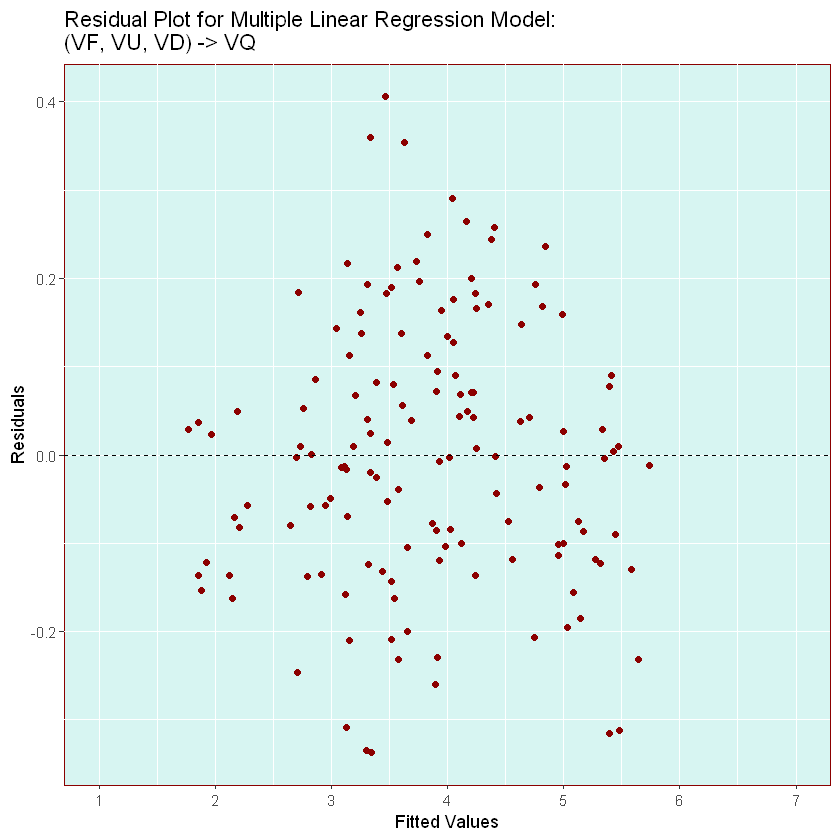

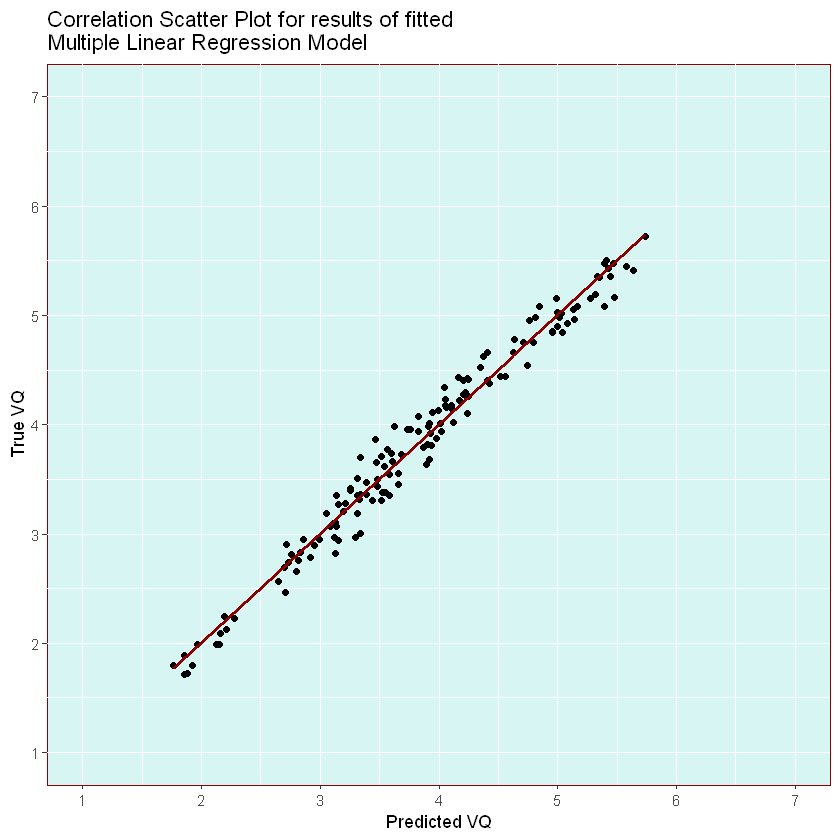

In [12]:
draw_residual_plot(y_hat, residuals)
draw_model_correlation_plot(gaming_data %>% select(VQ), predict(model))

#### Every p value < 0.05 [significant!] and residual plot does not look problematic => linear assumption not rejected at the moment

#### Significant correlation between independent variables (VF, VU) & (VF, VD) [p value < 0.05], BUT model has very high (adjusted) R-Squared value [nearly 1] and every coefficient's p value < 0.05, hence: interaction effect does not have to be included in model [would even diminish result quality here]!

#### Note: Correlation between true VQ and predicted VQ almost 1 :)